In [1]:
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline

import torch
import torch.nn as nn

from utils import utils

In [2]:
resource_path = os.path.join(".", 'data', 'ml-25m')
movies_csv = os.path.join(resource_path, 'movies.csv')
links_csv = os.path.join(resource_path, 'links.csv')

In [3]:
movies = pd.read_csv(movies_csv)
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies['genres'] = movies.genres.apply(lambda genres: genres.split('|'))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [6]:
links = pd.read_csv(links_csv, dtype = {
    'movieId': int, 'imdbId': str, 'tmdbId': str})
links.head()

,movieId,imdbId,tmdbId
0,1,0114709,862
1,2,0113497,8844
2,3,0113228,15602
3,4,0114885,31357
4,5,0113041,11862


In [7]:
movies = movies.merge(links)
del links

movies

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0114709,862
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0113497,8844
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0113228,15602
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",0114885,31357
4,5,Father of the Bride Part II (1995),[Comedy],0113041,11862
...,...,...,...,...,...
62418,209157,We (2018),[Drama],6671244,499546
62419,209159,Window of the Soul (2001),[Documentary],0297986,63407
62420,209163,Bad Poems (2018),"[Comedy, Drama]",6755366,553036
62421,209169,A Girl Thing (2001),[(no genres listed)],0249603,162892


In [8]:
model_path = os.path.join(".", 'models', 'binaries')
models = [model for model in os.listdir(model_path) if model.endswith(".pth")]
models.sort()
models

final_model = models[-1]
final_model_path = os.path.join(model_path, final_model)
final_model_path

'.\\models\\binaries\\Embedding_weights_Final.pth'

In [9]:
embedding_state = torch.load(final_model_path)

n_users = embedding_state['n_users']
n_movies = embedding_state['n_movies']
n_factors = embedding_state['n_factors']

movie_bias = embedding_state['state_dict']['movie_bias.weight']
movie_factors = embedding_state['state_dict']['movie_factors.weight']

userLabel_to_Id = embedding_state["userLabel_to_Id"]
movieLabel_to_Id = embedding_state["movieLabel_to_Id"]

del embedding_state

c:\ProgramData\anaconda3\envs\ncf\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.3.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
def get_movie_id(label):
    id = movieLabel_to_Id([label])
    return id.item(0)

movies_dict = {
    'label': [],
    'title': [],
    'genres':  [],
    'imdbId': []
}

for label in range(n_movies):
    movies_dict['label'].append(label)
    movies_dict['title'].append(movies[movies['movieId']==get_movie_id(label)]['title'].item())
    movies_dict['genres'].append(movies[movies['movieId']==get_movie_id(label)]['genres'].item())
    movies_dict['imdbId'].append(movies[movies['movieId']==get_movie_id(label)]['imdbId'].item())

movies = pd.DataFrame(movies_dict)
del movies_dict
movies

,label,title,genres,imdbId
0,0,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0114709
1,1,Jumanji (1995),"[Adventure, Children, Fantasy]",0113497
2,2,Heat (1995),"[Action, Crime, Thriller]",0113277
3,3,GoldenEye (1995),"[Action, Adventure, Thriller]",0113189
4,4,Ace Ventura: When Nature Calls (1995),[Comedy],0112281
...,...,...,...,...
195,195,Up (2009),"[Adventure, Animation, Children, Drama]",1049413
196,196,Avatar (2009),"[Action, Adventure, Sci-Fi, IMAX]",0499549
197,197,Inception (2010),"[Action, Crime, Drama, Mystery, Sci-Fi, Thrill...",1375666
198,198,Django Unchained (2012),"[Action, Drama, Western]",1853728


In [11]:
def get_movie_name(label):
    return movies[movies['label']==label]['title'].item()

In [12]:
ranked_labels = movie_bias.argsort(0, descending=True).squeeze().tolist()
for i, label in enumerate(ranked_labels):
    print(f"{i+1}. {get_movie_name(label)}")

1. Shawshank Redemption, The (1994)
2. Godfather, The (1972)
3. Usual Suspects, The (1995)
4. Godfather: Part II, The (1974)
5. Schindler's List (1993)
6. Fight Club (1999)
7. One Flew Over the Cuckoo's Nest (1975)
8. Pulp Fiction (1994)
9. Dark Knight, The (2008)
10. Matrix, The (1999)
11. Silence of the Lambs, The (1991)
12. American Beauty (1999)
13. Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
14. Goodfellas (1990)
15. American History X (1998)
16. Inception (2010)
17. Rear Window (1954)
18. Monty Python and the Holy Grail (1975)
19. Casablanca (1942)
20. Spirited Away (Sen to Chihiro no kamikakushi) (2001)
21. Memento (2000)
22. Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
23. Star Wars: Episode V - The Empire Strikes Back (1980)
24. Princess Bride, The (1987)
25. Blade Runner (1982)
26. Life Is Beautiful (La Vita è bella) (1997)
27. Star Wars: Episode IV - A New Hope (1977)
28. Lord of the Rings: The Return of the K

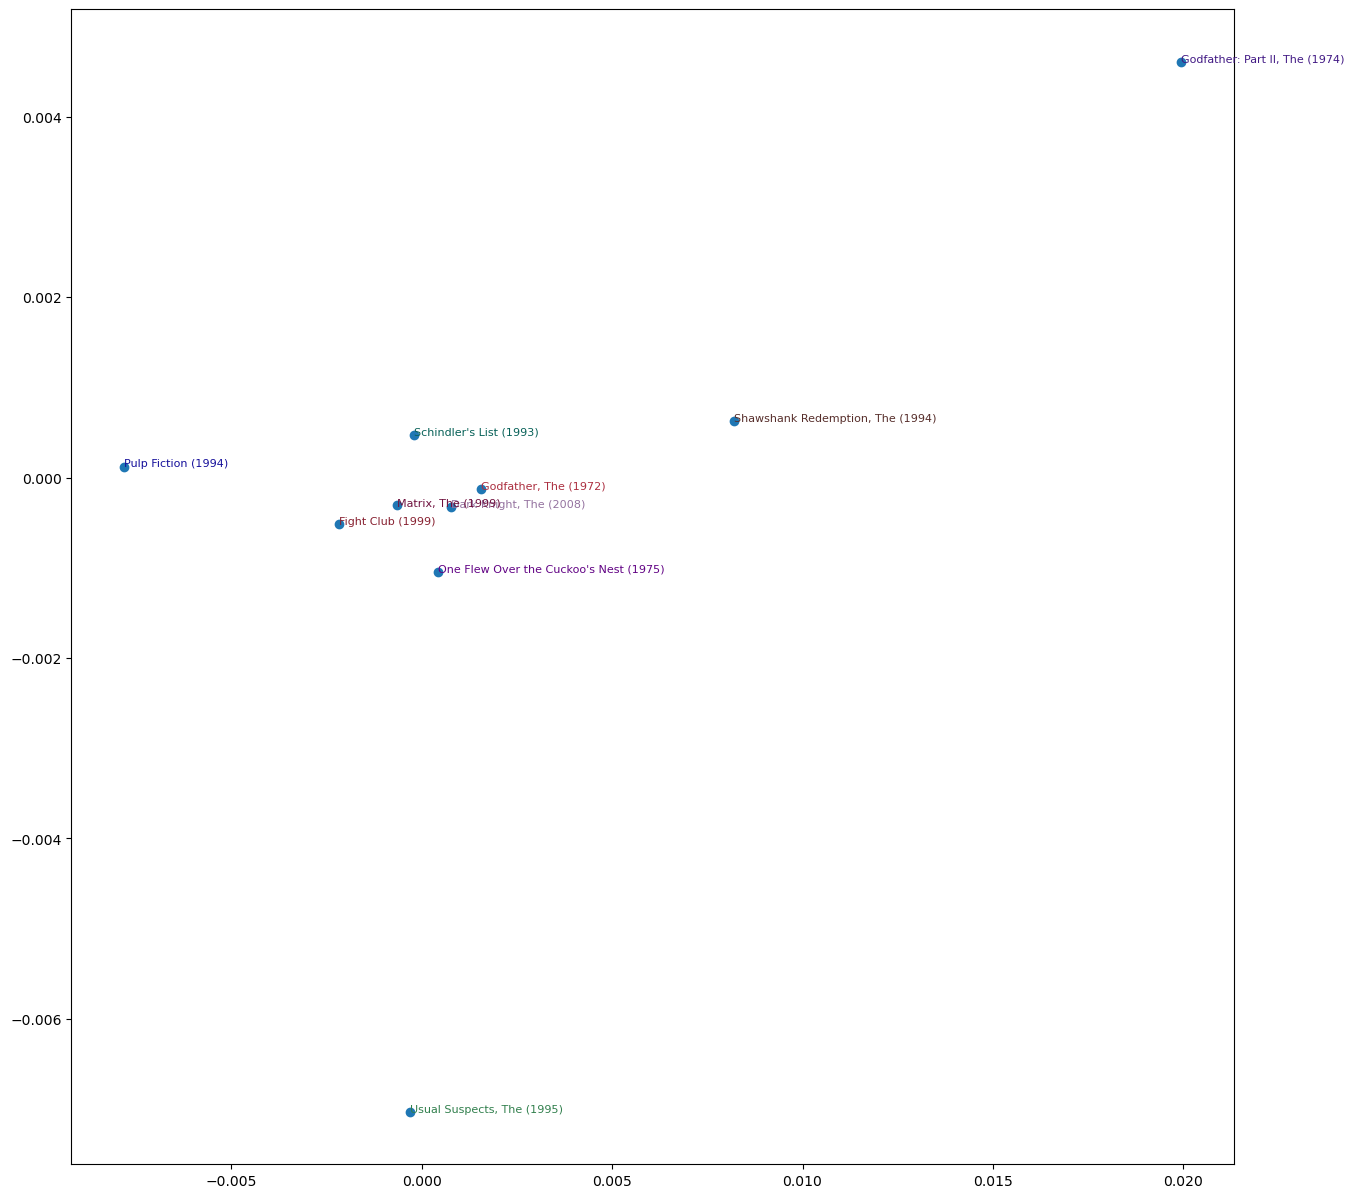

In [13]:
top_n = 10
top_n_labels = ranked_labels[:top_n]

pca = PCA(n_components=2)
reduced_embed = pca.fit_transform(movie_factors)
X = reduced_embed[top_n_labels][:,0]
Y = reduced_embed[top_n_labels][:,1]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for label, x, y in zip(top_n_labels,X, Y):
    plt.text(x,y, get_movie_name(label), color=np.random.rand(3)*0.7, fontsize=8)

In [14]:
def disp_ordered_movies(labels):
    for i, label in enumerate(labels):
        print(f"{i+1}. {get_movie_name(label)}")

In [15]:
label = 30
closest_labels = utils.get_closest_labels(label, movie_factors)

top_n = 20
print(f"Top {top_n} Closest Movies to {get_movie_name(label)} :")
disp_ordered_movies(closest_labels[:top_n])

Top 20 Closest Movies to Shawshank Redemption, The (1994) :
1. Pulp Fiction (1994)
2. Sleepless in Seattle (1993)
3. American Pie (1999)
4. Lord of the Rings: The Return of the King, The (2003)
5. Princess Bride, The (1987)
6. Harry Potter and the Chamber of Secrets (2002)
7. Jurassic Park (1993)
8. Incredibles, The (2004)
9. Contact (1997)
10. Bug's Life, A (1998)
11. Monty Python and the Holy Grail (1975)
12. Good Will Hunting (1997)
13. Mission: Impossible (1996)
14. Big Lebowski, The (1998)
15. Willy Wonka & the Chocolate Factory (1971)
16. Austin Powers: International Man of Mystery (1997)
17. Up (2009)
18. Star Wars: Episode I - The Phantom Menace (1999)
19. Minority Report (2002)
20. True Lies (1994)


In [16]:
label = 30
weight = 1
bias_weight = 0

recommendations = utils.get_recommendations(label, movie_factors, movie_bias, weight, bias_weight)
recommendations = sorted(recommendations.items(), key=lambda x:x[1], reverse=True)
recommendations = [label for label, _ in recommendations]


top_n = 20
print(f"Top {top_n} Recommended Movies for people who like {get_movie_name(label)} :")
disp_ordered_movies(recommendations[:top_n])

Top 20 Recommended Movies for people who like Shawshank Redemption, The (1994) :
1. Pulp Fiction (1994)
2. Sleepless in Seattle (1993)
3. American Pie (1999)
4. Lord of the Rings: The Return of the King, The (2003)
5. Princess Bride, The (1987)
6. Harry Potter and the Chamber of Secrets (2002)
7. Jurassic Park (1993)
8. Incredibles, The (2004)
9. Contact (1997)
10. Bug's Life, A (1998)
11. Monty Python and the Holy Grail (1975)
12. Good Will Hunting (1997)
13. Mission: Impossible (1996)
14. Big Lebowski, The (1998)
15. Willy Wonka & the Chocolate Factory (1971)
16. Austin Powers: International Man of Mystery (1997)
17. Up (2009)
18. Star Wars: Episode I - The Phantom Menace (1999)
19. Minority Report (2002)
20. True Lies (1994)


In [17]:
user_ratings = [(30, 4.8), (0, 3.5), (196, 3.0), (2, 2.3)]

recommendations = dict()
bias_weight = 0.3

for label, rating in user_ratings:
    recommendations = utils.get_recommendations(label, movie_factors, movie_bias, rating, bias_weight, recommendations)

recommendations = sorted(recommendations.items(), key=lambda x:x[1], reverse=True)
recommendations = [label for label, _ in recommendations]

top_n = 20
print(f"Top {top_n} Recommended Movies :")
disp_ordered_movies(recommendations[:top_n])

Top 20 Recommended Movies :
1. Matrix, The (1999)
2. Big Lebowski, The (1998)
3. Pulp Fiction (1994)
4. Princess Bride, The (1987)
5. Eternal Sunshine of the Spotless Mind (2004)
6. Good Will Hunting (1997)
7. Harry Potter and the Chamber of Secrets (2002)
8. Silence of the Lambs, The (1991)
9. Beautiful Mind, A (2001)
10. Monty Python and the Holy Grail (1975)
11. Blues Brothers, The (1980)
12. Inglourious Basterds (2009)
13. Green Mile, The (1999)
14. Die Hard (1988)
15. Goodfellas (1990)
16. American Beauty (1999)
17. Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)
18. Spirited Away (Sen to Chihiro no kamikakushi) (2001)
19. Incredibles, The (2004)
20. Willy Wonka & the Chocolate Factory (1971)
